In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader

In [2]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/zero-shot'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import create_sliding_windows, SequentialDeepONetDataset
from helper import load_model_experiment, convert2dim, train_val_test_split, plot_global_field_cartopy, plot_global_field_box

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
#------------------------------
# Load model
#------------------------------
model_path = 'single_branch/lstm_window_30.pth'

model = load_model_experiment(model_path).to(device)

print(model)

/projects/bcnx/kazumak2/CosmicRays-Operator/analysis/zero-shot/helper.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loaded model from single_branch/lstm_window_30.pth
SequentialDeepONet(
  (branch_net): LSTM(
    (lstm): LSTM(12, 128, num_layers=4, batch_first=True)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=128, out_features=128, bias=True)
  )
  (trunk_net): FCN(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)


In [4]:
#------------------------------
# Load test input function (unseen 2023 data)
# Load test target (resolution 1 deg)
#------------------------------
input_sensor = np.load('data/neutron_data_22yrs.npy')

# 1 degree target
output_1deg = np.load('data/dose_array.npy')

# 0.25 degree target
output_025deg = np.load('data/DoseNumpy025/dose_2001_2023_0m.npy')

In [5]:
# data splitting keeping the consistency with training phase
train_input_1, train_target_1, val_input_1, val_target_1, test_input_1, test_target_1 = train_val_test_split(input_sensor, output_1deg)
train_input_025, train_target_025, val_input_025, val_target_025, test_input_025, test_target_025 = train_val_test_split(input_sensor, output_025deg)

# remove output_1deg and output_025deg from memory
del output_1deg
del output_025deg

Train input shape: (4017, 12)
Validation input shape: (4018, 12)
Test input shape: (365, 12)
Train input shape: (4017, 12)
Validation input shape: (4018, 12)
Test input shape: (365, 12)


In [6]:
# input scaler
scaler = MinMaxScaler()

# the input data is common for both 1 deg and 0.25 deg targets
# so we fit the scaler only once using train_input_1
dummy = scaler.fit_transform(train_input_1)
test_input_1 = scaler.transform(test_input_1)
test_input_025 = scaler.transform(test_input_025)

# target data normalization (min-max scaling)
scaler_target_1 = MinMaxScaler()
train_target_1 = scaler_target_1.fit_transform(train_target_1)[..., np.newaxis]
test_target_1 = scaler_target_1.transform(test_target_1)[..., np.newaxis]

scaler_target_025 = MinMaxScaler()
train_target_025 = scaler_target_025.fit_transform(train_target_025)[..., np.newaxis]
test_target_025 = scaler_target_025.transform(test_target_025)[..., np.newaxis]

In [7]:
# location points for 1 degree target
trunk_1deg = np.load('data/grid_points.npy')
trunk_025deg = np.load('data/grid_points_025.npy')

print('location range (1 deg):', np.min(trunk_1deg[:,0]), np.max(trunk_1deg[:,0]), np.min(trunk_1deg[:,1]), np.max(trunk_1deg[:,1]))
print('location range (0.25 deg):', np.min(trunk_025deg[:,0]), np.max(trunk_025deg[:,0]), np.min(trunk_025deg[:,1]), np.max(trunk_025deg[:,1]))

# Normalize trunk input
trunk_1deg[:, 0] = (trunk_1deg[:, 0] - np.min(trunk_1deg[:, 0])) / (np.max(trunk_1deg[:, 0]) - np.min(trunk_1deg[:, 0]))
trunk_1deg[:, 1] = (trunk_1deg[:, 1] - np.min(trunk_1deg[:, 1])) / (np.max(trunk_1deg[:, 1]) - np.min(trunk_1deg[:, 1]))

trunk_025deg[:, 0] = (trunk_025deg[:, 0] - np.min(trunk_025deg[:, 0])) / (np.max(trunk_025deg[:, 0]) - np.min(trunk_025deg[:, 0]))
trunk_025deg[:, 1] = (trunk_025deg[:, 1] - np.min(trunk_025deg[:, 1])) / (np.max(trunk_025deg[:, 1]) - np.min(trunk_025deg[:, 1]))

location range (1 deg): -90.0 90.0 -180.0 180.0
location range (0.25 deg): -90.0 90.0 -180.0 180.0


In [8]:
# Generate sequences for the testing set
test_input_seq_1, test_target_seq_1 = create_sliding_windows(test_input_1, test_target_1, window_size=30)

print('test_input_seq shape:', test_input_seq_1.shape)
print('test_target_seq shape:', test_target_seq_1.shape)

test_input_seq_025, test_target_seq_025 = create_sliding_windows(test_input_025, test_target_025, window_size=30)

print('test_input_seq_025 shape:', test_input_seq_025.shape)
print('test_target_seq_025 shape:', test_target_seq_025.shape)

test_input_seq shape: torch.Size([336, 30, 12])
test_target_seq shape: torch.Size([336, 65341, 1])
test_input_seq_025 shape: torch.Size([336, 30, 12])
test_target_seq_025 shape: torch.Size([336, 1038961, 1])


In [9]:
# Create DataLoader for test set
test_dataset_1 = SequentialDeepONetDataset(test_input_seq_1, trunk_1deg, test_target_seq_1)
test_loader_1 = DataLoader(test_dataset_1, batch_size=1, shuffle=False)

test_dataset_025 = SequentialDeepONetDataset(test_input_seq_025, trunk_025deg, test_target_seq_025)
test_loader_025 = DataLoader(test_dataset_025, batch_size=1, shuffle=False)

In [10]:
def fit(model, data_loader, device, scaler_target):
    all_outputs = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for branch_batch, trunk_batch, target_batch in data_loader:
            branch_batch, trunk_batch, target_batch = (
                branch_batch.to(device),
                trunk_batch.to(device),
                target_batch.to(device),
            )
            output = model(branch_batch, trunk_batch)
            
            all_outputs.append(output.cpu())
            all_targets.append(target_batch.cpu())

    # ...existing code...
    # After loop:
    outputs = torch.cat(all_outputs, dim=0)  # [N_test, ...]
    targets = torch.cat(all_targets, dim=0)  # [N_test, ...]

    # move to numpy
    outputs = outputs.cpu().numpy()
    targets = targets.cpu().numpy()

    # flatten to 2D (n_samples, n_features) for scaler
    out_shape = outputs.shape
    tgt_shape = targets.shape
    outputs_flat = outputs.reshape(outputs.shape[0], -1)
    targets_flat = targets.reshape(targets.shape[0], -1)

    # inverse scale
    outputs_flat = scaler_target.inverse_transform(outputs_flat)
    targets_flat = scaler_target.inverse_transform(targets_flat)

    # restore original shapes
    outputs = outputs_flat.reshape(out_shape)
    targets = targets_flat.reshape(tgt_shape)
    # ...existing code...

    
    return outputs, targets

In [11]:
predictions_1deg, targets_1deg = fit(model, test_loader_1, device, scaler_target_1)
print('predictions shape:', predictions_1deg.shape)
print('targets shape:', targets_1deg.shape)

predictions_025deg, targets_025deg = fit(model, test_loader_025, device, scaler_target_025)
print('predictions shape:', predictions_025deg.shape)
print('targets shape:', targets_025deg.shape)

predictions shape: (336, 65341, 1)
targets shape: (336, 65341, 1)
predictions shape: (336, 1038961, 1)
targets shape: (336, 1038961, 1)


In [12]:
lon_grid_1, lat_grid_1, pred_img_1 = convert2dim(predictions_1deg)  # (N,H,W)
_,        _,        targ_img_1 = convert2dim(targets_1deg)      # (N,H,W)

lon_grid_025, lat_grid_025, pred_img_025 = convert2dim(predictions_025deg, grid_path='data/grid_points_025.npy')  # (N,H,W)
_,          _,          targ_img_025 = convert2dim(targets_025deg, grid_path='data/grid_points_025.npy')      # (N,H,W)


# print pred sizes
print('1 deg pred_img shape:', pred_img_1.shape)
print('0.25 deg pred_img shape:', pred_img_025.shape)

print('1 deg targ_img shape:', targ_img_1.shape)
print('0.25 deg targ_img shape:', targ_img_025.shape)

1 deg pred_img shape: (336, 181, 361)
0.25 deg pred_img shape: (336, 721, 1441)
1 deg targ_img shape: (336, 181, 361)
0.25 deg targ_img shape: (336, 721, 1441)


In [13]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

def compute_metrics(pred_img, targ_img):
    ''' 
    Compute and print evaluation metrics between predicted and target images.
    Both inputs should be numpy arrays of shape (N, H, W), where N is the number of samples.
    '''

    pred_img = pred_img.astype(np.float64)
    targ_img = targ_img.astype(np.float64)

    N = pred_img.shape[0]
    eps = 1e-12

    # ---- Relative L2 (%) per-sample + mean ----
    pf = pred_img.reshape(N, -1)
    tf = targ_img.reshape(N, -1)
    rel_l2_pct = 100.0 * np.linalg.norm(pf - tf, axis=1) / (np.linalg.norm(tf, axis=1) + eps)
    print("Mean Relative L2 (%):", rel_l2_pct.mean())

    # ---- SSIM per-sample + mean (uses target’s per-sample dynamic range) ----
    ssim_scores = np.empty(N, dtype=float)
    for i in range(N):
        dr = float(targ_img[i].max() - targ_img[i].min()) or 1.0
        ssim_scores[i] = ssim(targ_img[i], pred_img[i], data_range=dr)
    print("Mean SSIM:", ssim_scores.mean())
    
    return rel_l2_pct, ssim_scores

In [14]:
rel_l2_1deg, ssim_1deg = compute_metrics(pred_img_1, targ_img_1)
rel_l2_025deg, ssim_025deg = compute_metrics(pred_img_025, targ_img_025)

Mean Relative L2 (%): 0.11222334735853823
Mean SSIM: 0.9993264089659769
Mean Relative L2 (%): 0.11207333520306922
Mean SSIM: 0.9998753297197576


In [15]:
import pandas as pd

def make_sequence_windows(year: int, seq_len: int = 30, leap: bool = True):
    """
    Create sequence window metadata for EXPACS daily data,
    where target_date == end_date (same-day prediction).

    Parameters
    ----------
    year : int
        Target simulation year (e.g., 2023)
    seq_len : int, optional
        Number of days per input sequence (default: 30)
    leap : bool, optional
        Whether to include Feb 29 in leap years (default: True)

    Returns
    -------
    windows : pd.DataFrame
        Columns:
          - 'start_date': first day of input sequence
          - 'end_date': last day of input sequence (== target)
          - 'target_date': same as end_date
          - 'index': sequential integer index (0, 1, 2, …)
    """

    # Determine number of days in this year
    n_days = 366 if (leap and pd.Timestamp(year=year, month=12, day=31).is_leap_year) else 365

    # Build full daily timeline
    dates = pd.date_range(f"{year}-01-01", periods=n_days, freq="D")

    start_dates, end_dates, target_dates = [], [], []

    # Sliding windows
    for i in range(seq_len - 1, n_days):
        start_dates.append(dates[i - seq_len + 1])
        end_dates.append(dates[i])
        target_dates.append(dates[i])   # same as end_date

    df = pd.DataFrame({
        "index": range(len(target_dates)),
        "start_date": start_dates,
        "end_date": end_dates,
        "target_date": target_dates
    })

    return df


# =============================
# Example usage
# =============================
year = 2023
seq_len = 30
meta = make_sequence_windows(year, seq_len)

print(meta.head(5))
print(f"\nTotal windows: {len(meta)}")


   index start_date   end_date target_date
0      0 2023-01-01 2023-01-30  2023-01-30
1      1 2023-01-02 2023-01-31  2023-01-31
2      2 2023-01-03 2023-02-01  2023-02-01
3      3 2023-01-04 2023-02-02  2023-02-02
4      4 2023-01-05 2023-02-03  2023-02-03

Total windows: 336


In [16]:
year = 2023
seq_len = 30
meta = make_sequence_windows(year, seq_len)

print(meta.head())

target_date = meta['target_date'].to_numpy()

   index start_date   end_date target_date
0      0 2023-01-01 2023-01-30  2023-01-30
1      1 2023-01-02 2023-01-31  2023-01-31
2      2 2023-01-03 2023-02-01  2023-02-01
3      3 2023-01-04 2023-02-02  2023-02-02
4      4 2023-01-05 2023-02-03  2023-02-03


Median L2 (1°): 0.10562828554433376
Date: 2023-02-23T00:00:00.000000000


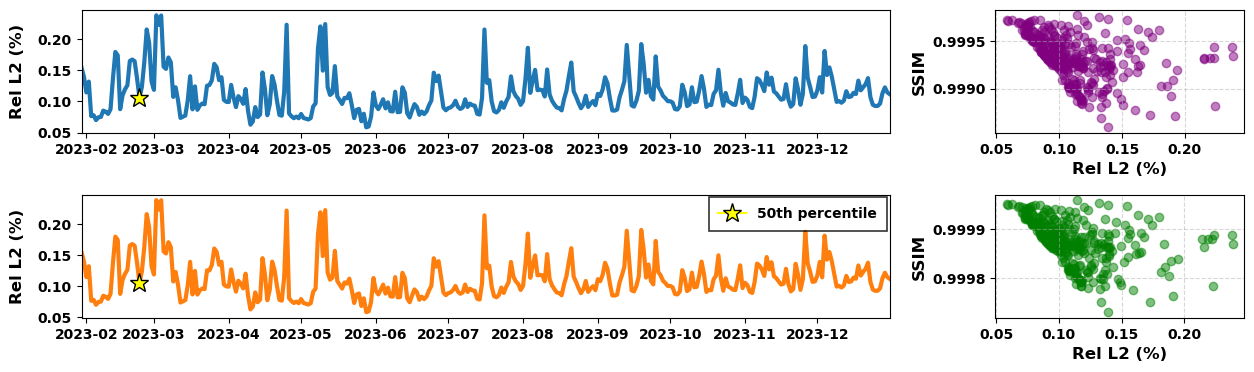

In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
import numpy as np

# --- Compute 50th percentile and corresponding date ---
rel_l2_1deg_50pct = np.percentile(rel_l2_1deg, 50)
idx_50pct_1deg = np.argmin(np.abs(rel_l2_1deg - rel_l2_1deg_50pct))
date_50pct_1deg = target_date[idx_50pct_1deg]
print("Median L2 (1°):", rel_l2_1deg_50pct)
print("Date:", date_50pct_1deg)

# --- Create figure ---
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(
    2, 4, figure=fig,
    width_ratios=[10, 1, 1, 5],
    height_ratios=[1, 1],
    wspace=0.5, hspace=0.5
)

fontsize = 12

# =====================================================
# Row 1: 1° data (top)
# =====================================================
ax1 = fig.add_subplot(gs[0, 0:3])
ax1.set_ylabel('Rel L2 (%)', fontweight='bold', fontsize=fontsize)
line1, = ax1.plot(target_date, rel_l2_1deg, color='tab:blue', linewidth=3)
ax1.set_xlim([target_date[0], target_date[-1]])

# Add yellow star marker for 50th percentile
star1, = ax1.plot(date_50pct_1deg, rel_l2_1deg[idx_50pct_1deg],
                  marker='*', color='yellow', markersize=14,
                  markeredgecolor='black', label='50th percentile')

ax2 = fig.add_subplot(gs[0, 3])
ax2.scatter(rel_l2_1deg, ssim_1deg, color='purple', alpha=0.5)
ax2.set_xlabel("Rel L2 (%)", fontweight='bold', fontsize=fontsize)
ax2.set_ylabel("SSIM", fontweight='bold', fontsize=fontsize)

# =====================================================
# Row 2: 0.25° data (bottom)
# =====================================================
ax3 = fig.add_subplot(gs[1, 0:3])
ax3.set_ylabel('Rel L2 (%)', fontweight='bold', fontsize=fontsize)
line2, = ax3.plot(target_date, rel_l2_025deg, color='tab:orange', linewidth=3)
ax3.set_xlim([target_date[0], target_date[-1]])

# Add yellow star marker at same date (nearest match)
idx_50pct_025deg = np.argmin(np.abs(target_date - date_50pct_1deg))
star2, = ax3.plot(date_50pct_1deg, rel_l2_025deg[idx_50pct_025deg],
                  marker='*', color='yellow', markersize=14,
                  markeredgecolor='black', label='50th percentile')

ax4 = fig.add_subplot(gs[1, 3])
ax4.scatter(rel_l2_025deg, ssim_025deg, color='green', alpha=0.5)
ax4.set_xlabel("Rel L2 (%)", fontweight='bold', fontsize=fontsize)
ax4.set_ylabel("SSIM", fontweight='bold', fontsize=fontsize)

# =====================================================
# Formatting
# =====================================================
# Tick formatting
for ax in [ax1, ax3]:
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

for ax in [ax2, ax4]:
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    ax.grid(True, linestyle='--', alpha=0.5)

# Make all tick labels bold
for ax in [ax1, ax2, ax3, ax4]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

# Align y-labels in first column
ax1.yaxis.set_label_coords(-0.07, 0.5)
ax3.yaxis.set_label_coords(-0.07, 0.5)


# Filter out any automatically generated artists
handles = [h for h in [line2, star2] if not h.get_label().startswith('_')]

legend2 = ax3.legend(handles=handles,
                     frameon=True,
                     edgecolor='black',
                     facecolor='none',
                     fontsize=10,
                     loc='upper right')

# Make legend text bold and border a bit thicker
for text in legend2.get_texts():
    text.set_fontweight('bold')
legend2.get_frame().set_linewidth(1.2)
legend2.get_frame().set_boxstyle('Square')

plt.show()

In [18]:
from helper import plot_global_field_cartopy, plot_global_field_box

In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

In [20]:
# helper for plotting
def _edges_from_centers(centers):
    centers = np.asarray(centers)
    if centers.ndim != 1 or centers.size < 2:
        raise ValueError("centers must be 1D with >=2 elements")
    edges = np.empty(centers.size + 1, dtype=centers.dtype)
    edges[1:-1] = 0.5 * (centers[:-1] + centers[1:])
    edges[0] = centers[0] - 0.5 * (centers[1] - centers[0])
    edges[-1] = centers[-1] + 0.5 * (centers[-1] - centers[-2])
    return edges

In [21]:
# for plotting setting
Lon = lon_grid_025
Lat = lat_grid_025
field = pred_img_025
error = np.abs(targ_img_025 - pred_img_025)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_field_region(
    lon_grid, lat_grid, field, i=0, *,
    title=None, units_label="value",
    cmap="viridis", vmin=None, vmax=None,
    region_extent=None,     # [lon_min, lon_max, lat_min, lat_max]
    show_coast=True, show_borders=True,
    tick_step=(10, 5),
    add_contour=False, contour_levels=8, contour_color="k", contour_alpha=0.8,
    mark_equator_meridian=True,
    savepath=None, dpi=300, close=True
):
    """Regional map with *exactly aligned* colorbar under the plot."""
    assert field.ndim == 3 and 0 <= i < field.shape[0]
    lon_min, lon_max, lat_min, lat_max = region_extent

    # --- Subset region ---
    mask_lat = (lat_grid[:, 0] >= lat_min) & (lat_grid[:, 0] <= lat_max)
    mask_lon = (lon_grid[0, :] >= lon_min) & (lon_grid[0, :] <= lon_max)
    sub_field = field[i][np.ix_(mask_lat, mask_lon)]
    sub_lon = lon_grid[np.ix_(mask_lat, mask_lon)]
    sub_lat = lat_grid[np.ix_(mask_lat, mask_lon)]

    # --- Setup ---
    proj = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw={'projection': proj})

    # --- Base map ---
    if show_coast:
        ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
        ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=0)
        ax.coastlines(resolution="50m", lw=0.6)
    if show_borders:
        ax.add_feature(cfeature.BORDERS, lw=0.4)

    # --- Main field ---
    im = ax.pcolormesh(
        sub_lon, sub_lat, sub_field,
        transform=proj, cmap=cmap, vmin=vmin, vmax=vmax, shading="auto"
    )

    # --- Contours ---
    if add_contour:
        cs = ax.contour(
            sub_lon, sub_lat, sub_field,
            levels=contour_levels, colors=contour_color,
            linewidths=0.4, alpha=contour_alpha, transform=proj
        )
        ax.clabel(cs, fmt="%.3f", fontsize=6, inline=True, inline_spacing=2)

    # --- Set extent ---
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)

    # --- Manual ticks ---
    lon_step, lat_step = tick_step
    xticks = np.arange(lon_min, lon_max + lon_step, lon_step)
    yticks = np.arange(lat_min, lat_max + lat_step, lat_step)
    ax.set_xticks(xticks, crs=proj)
    ax.set_yticks(yticks, crs=proj)

    def fmt_lon(x):
        return f"{abs(int(x))}°{'W' if x < 0 else 'E' if x > 0 else ''}"

    def fmt_lat(y):
        return f"{abs(int(y))}°{'S' if y < 0 else 'N' if y > 0 else ''}"

    ax.set_xticklabels([fmt_lon(x) for x in xticks], fontsize=9)
    ax.set_yticklabels([fmt_lat(y) for y in yticks], fontsize=9)
    ax.tick_params(length=3, direction="out")

    # --- Optional equator/meridian lines ---
    if mark_equator_meridian:
        ax.plot([lon_min, lon_max], [0, 0], transform=proj, color="gray", lw=0.5, ls="--")
        if lon_min < 0 < lon_max:
            ax.plot([0, 0], [lat_min, lat_max], transform=proj, color="gray", lw=0.5, ls="--")

    # --- Title ---
    if title:
        ax.set_title(title, fontsize=12, pad=6)

    # ======================================================
    #  COLORBAR PERFECTLY ALIGNED AFTER DRAW
    # ======================================================
    plt.tight_layout()
    fig.canvas.draw_idle()  # ensure layout is applied
    renderer = fig.canvas.get_renderer()
    pos = ax.get_position()  # [x0, y0, width, height] in figure coords

    # exact alignment with map
    cbar_height = 0.04
    cbar_bottom = pos.y0 - 0.15  # spacing below map
    cbar_left = pos.x0
    cbar_width = pos.width

    cax = fig.add_axes([cbar_left, cbar_bottom, cbar_width, cbar_height])
    cb = fig.colorbar(im, cax=cax, orientation='horizontal')
    cb.set_label(units_label, fontsize=10)
    cb.ax.tick_params(labelsize=8)

    if savepath:
        plt.savefig(savepath, dpi=dpi, bbox_inches="tight")
    else:
        plt.show()
    if close:
        plt.close(fig)


In [23]:
import cmocean
cmap_seq = cmocean.cm.ice

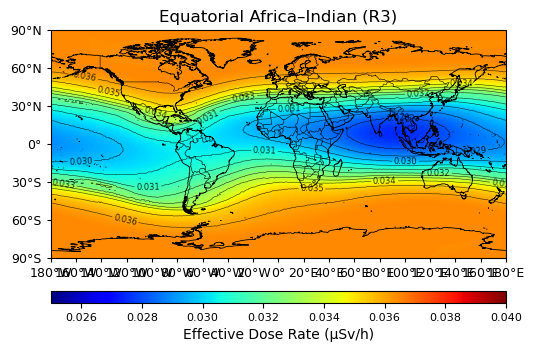

<Figure size 600x300 with 0 Axes>

In [37]:
plot_field_region(
    Lon, Lat, field, i=10,
    title="Equatorial Africa–Indian (R3)",
    units_label="Effective Dose Rate (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0.025, vmax=0.040,
    tick_step=(20, 30),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 20),
    mark_equator_meridian=False,
    cmap='jet'
)
plt.gcf().set_size_inches(6, 3)
